In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist
import tensorflow as tf
from tensorflow.keras.layers import Dense, Reshape, Dropout, LeakyReLU, Flatten, BatchNormalization, Conv2D,Conv2DTranspose
from tensorflow.keras.models import Sequential

**LOAD DATASET**

In [2]:
(X_train, _), (_, _) = mnist.load_data()

X_train = (X_train / 127.5) - 1.0
X_train = X_train.reshape(-1, 28, 28, 1)

11490434/11490434 [==============================] - 1s 0us/step


In [3]:
np.random.seed(42)
tf.random.set_seed(42)

coding_size = 100

**MODEL**

In [4]:
class Generator(tf.keras.Model):
    def __init__(self, coding_size):
        super(Generator, self).__init__()
        self.dense1 = Dense(7 * 7 * 128, input_shape=[coding_size])  # İlk katman
        self.reshape = Reshape([7, 7, 128])
        self.batch_norm1 = BatchNormalization()
        self.conv2d_transpose1 = Conv2DTranspose(64, kernel_size=5, strides=1, padding="same", activation=tf.nn.leaky_relu)
        self.batch_norm2 = BatchNormalization()
        self.conv2d_transpose2 = Conv2DTranspose(32, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu)
        self.batch_norm3 = BatchNormalization()
        self.conv2d_transpose3 = Conv2DTranspose(1, kernel_size=5, strides=2, padding="same", activation="tanh")

    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.reshape(x)
        x = self.batch_norm1(x)
        x = self.conv2d_transpose1(x)
        x = self.batch_norm2(x)
        x = self.conv2d_transpose2(x)
        x = self.batch_norm3(x)
        x = self.conv2d_transpose3(x)
        return x

In [5]:
class Discriminator(tf.keras.Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv2d1 = Conv2D(64, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu, input_shape=[28, 28, 1])
        self.dropout1 = Dropout(0.3)
        self.conv2d2 = Conv2D(128, kernel_size=5, strides=2, padding="same", activation=tf.nn.leaky_relu)
        self.dropout2 = Dropout(0.3)
        self.flatten = Flatten()
        self.dense = Dense(1, activation="sigmoid")

    def call(self, inputs):
        x = self.conv2d1(inputs)
        x = self.dropout1(x)
        x = self.conv2d2(x)
        x = self.dropout2(x)
        x = self.flatten(x)
        x = self.dense(x)
        return x

In [6]:
class GAN(tf.keras.Model):
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator

    def call(self, inputs):
        generated_images = self.generator(inputs)
        outputs = self.discriminator(generated_images)
        return outputs

In [7]:
LR = 0.001
beta_1 = 0.5
beta_2 = 0.999

optimizerD = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=beta_1, beta_2=beta_2)

optimizerG = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=beta_1, beta_2=beta_2)

discriminator = Discriminator()
discriminator.compile(loss="binary_crossentropy", optimizer=optimizerD)

discriminator.trainable = False

generator = Generator(coding_size)
gan = GAN(generator, discriminator)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)

In [8]:
batch_size = 32
my_data = X_train
dataset = tf.data.Dataset.from_tensor_slices(my_data).shuffle(buffer_size=1000)
dataset = dataset.batch(batch_size, drop_remainder=True).prefetch(1)

epochs = 25

**TRAIN**

In [9]:
def train(dataset, epochs, batch_size, coding_size, gan):
    generator, discriminator = gan.generator, gan.discriminator
    steps_per_epoch = len(dataset)
    total_steps = epochs * steps_per_epoch
    progress_step = total_steps // 100
    progress_count = 0

    for epoch in range(epochs):
        print(f"Epoch {epoch+1} / {epochs}")
        for step, X_batch in enumerate(dataset):
            noise = tf.random.normal(shape=[batch_size, coding_size])
            generated_images = generator(noise)
            X_fake_vs_real = tf.concat([generated_images, tf.dtypes.cast(X_batch, tf.float32)], axis=0)

            y1 = tf.concat([tf.zeros((batch_size, 1)), tf.ones((batch_size, 1))], axis=0)

            discriminator.trainable = True
            d_loss = discriminator.train_on_batch(X_fake_vs_real, y1)

            noise = tf.random.normal(shape=[batch_size, coding_size])
            y2 = tf.ones((batch_size, 1))

            discriminator.trainable = False

            g_loss = gan.train_on_batch(noise, y2)

            progress_count += 1
            if progress_count % progress_step == 0:
                progress_percentage = progress_count / total_steps * 100
                print(f"\tProgress: {progress_percentage:.1f}% - D loss: {d_loss}, G loss: {g_loss}")

        print("\tEpoch completed.")

In [10]:
train(dataset, epochs, batch_size, coding_size, gan)

Epoch 1 / 25
	Progress: 1.0% - D loss: 0.5937610268592834, G loss: 1.2149364948272705
	Progress: 2.0% - D loss: 0.6055449843406677, G loss: 0.9059280157089233
	Progress: 3.0% - D loss: 0.5390269160270691, G loss: 0.9124847650527954
	Progress: 4.0% - D loss: 0.6106844544410706, G loss: 0.8072868585586548
	Epoch completed.
Epoch 2 / 25
	Progress: 5.0% - D loss: 0.5648958683013916, G loss: 0.939570426940918
	Progress: 6.0% - D loss: 0.6850405931472778, G loss: 0.9871491193771362
	Progress: 7.0% - D loss: 0.5039366483688354, G loss: 1.2503173351287842
	Progress: 8.0% - D loss: 0.5783897042274475, G loss: 1.3772598505020142
	Epoch completed.
Epoch 3 / 25
	Progress: 9.0% - D loss: 0.5056690573692322, G loss: 1.1629974842071533
	Progress: 10.0% - D loss: 0.4737761616706848, G loss: 1.2622480392456055
	Progress: 11.0% - D loss: 0.5662506818771362, G loss: 1.1252739429473877
	Progress: 12.0% - D loss: 0.5591875910758972, G loss: 1.1236398220062256
	Epoch completed.
Epoch 4 / 25
	Progress: 13.0%

**TEST**

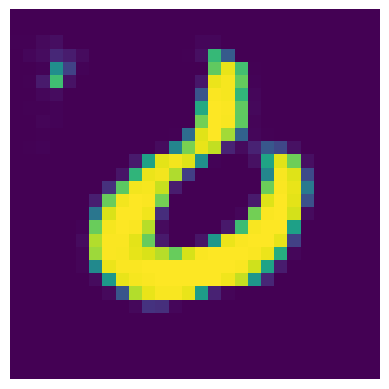

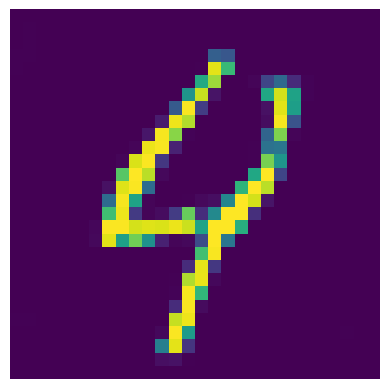

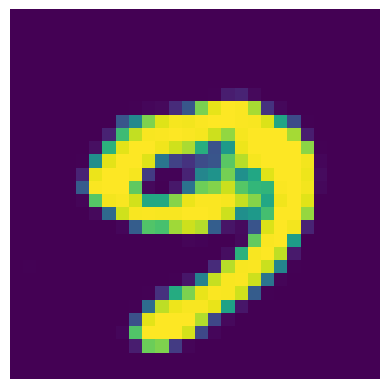

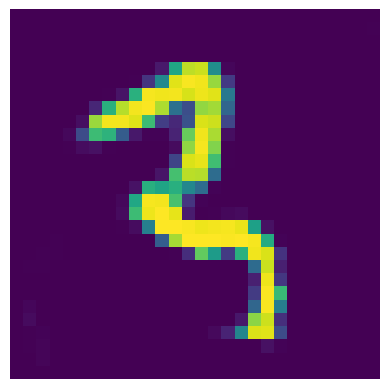

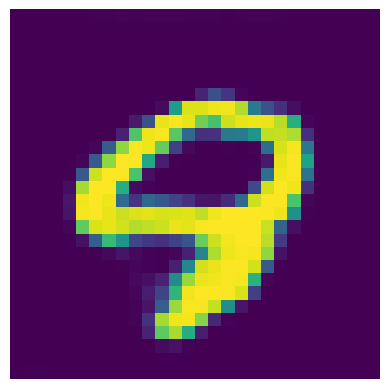

In [13]:
noise = tf.random.normal(shape=[5, coding_size])
images = generator(noise)

for i in range(5):
    plt.imshow(images[i].numpy().reshape(28, 28))
    plt.axis('off')
    plt.show()
